## Non-exonic windows, with Gnocchi and various features (e.g. GC content), and enhancer-overlap status 

In [1]:
from get_windows import get_windows_with_GC_content_and_cpg_islands 

WINDOWS = get_windows_with_GC_content_and_cpg_islands()
WINDOWS 

/scratch/ucgd/lustre-labs/quinlan/data-shared/constraint-tools


,chrom,start,end,gnocchi,N_observed,window overlaps enhancer,window overlaps merged_exon,B,paternal_recombination_rate,maternal_recombination_rate,...,B1_M3starHMT6.EUR,Bmean_M3starHMT6.EUR,lambda_M3starHMT6.EUR,GC_content_1000bp,GC_content_10000bp,GC_content_100000bp,GC_content_1000000bp,cpg_island_overlap,window_overlaps_cpg_island,N_mean_null_gnocchi
0,chr1,1432000,1433000,4.299894,259,True,False,0.653,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.661339,0.641836,0.565094,0.577534,NaN,False,338.059552
1,chr1,1451000,1452000,0.666316,291,False,False,0.652,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.556444,0.552845,0.572894,0.575506,NaN,False,302.590657
2,chr1,1453000,1454000,0.828398,256,False,False,0.651,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.537463,0.561944,0.572564,0.575129,NaN,False,269.601925
3,chr1,1458000,1459000,-0.086128,272,False,False,0.651,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.532468,0.596740,0.570774,0.575225,NaN,False,270.583243
4,chr1,1463000,1464000,2.948188,191,True,False,0.651,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.540460,0.568843,0.576514,0.574420,NaN,False,236.321790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019146,chr9,137262000,137263000,-2.396149,302,True,False,0.536,0.057053,0.063434,...,3.636507,0.219258,2.281162,0.500499,0.542646,0.611944,0.568316,45.0,True,263.131293
1019147,chr9,137268000,137269000,3.640544,212,True,False,0.536,0.057053,0.063434,...,3.636507,0.219258,2.281162,0.552448,0.589941,0.613074,0.567839,NaN,False,272.046527
1019148,chr9,137269000,137270000,5.276351,209,True,False,0.536,0.057053,0.063434,...,3.636507,0.219258,2.281162,0.519481,0.585042,0.613494,0.567623,NaN,False,300.458958
1019149,chr9,137275000,137276000,2.687348,290,True,False,0.536,1.564889,0.024254,...,3.636507,0.219258,2.281162,0.603397,0.639236,0.610484,0.567380,NaN,False,339.517045


## Gaussian Naive-Bayes model

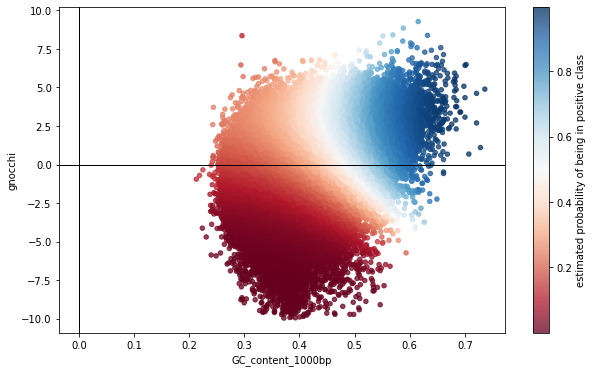

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import numpy as np

def f(df, gc_window_size):
  features = ['gnocchi', f'GC_content_{gc_window_size}bp']
  X = df[features]
  y = df['window overlaps enhancer']

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Create an instance of the model
  model = GaussianNB()

  # Fit the model to the training data
  model.fit(X_train, y_train)

  # Predict the probabilities of "window overlaps enhancer" == True on the testing data
  estimated_probabilities = model.predict_proba(X_test)[:, 1]

  x = np.array(X_test[features[1]])
  y = np.array(X_test[features[0]])
  c = estimated_probabilities

  # https://github.com/pandas-dev/pandas/issues/10611#issuecomment-522327555
  fig, axis = plt.subplots(figsize=(10,6))
  plt.scatter(x, y, c=c, s=20, cmap='RdBu', alpha=0.75) 
  plt.xlabel(features[1])
  plt.ylabel(features[0])
  cbar = plt.colorbar()
  cbar.set_label('estimated probability of being in positive class')
  plt.axhline(linewidth=1, color='black')
  plt.axvline(linewidth=1, color='black')
  plt.show() 

f(WINDOWS, 1000)

In [3]:
# TODO: 

# can effect size of GC content, etc be inferred from GaussianNB model, or must we use logistic regression?
# Can GaussianNB model correlations between features? 
# compare LRT statistic from gnocchi, gnocchi+GC, gnocchi+BGS, gnocchi+gBGC, etc to demonstrate which features have the greatest effect on the probability of a window overlapping an enhancer
# Assess performance by comparing the predicted probabilities to the fraction of windows that overlap enhancers in the test set in bins of gnocchi and GC content: papers/neutral_models_are_biased/3.ipynb
# [Aaron] Show that inclusion of extra features hardly impacts overall performance of model, but does when conditioned on, e.g., tail of GC content 


## Logistic regression

In [10]:
GC_WINDOW_SIZE = 1000

1019151
1018648
Coefficient for gnocchi: 0.3861763652885759
Coefficient for GC_content_1000bp: 0.46042959557111546
Coefficient for B_M1star.EUR: 0.06279635349405419
Coefficient for B: -0.09050560176900056


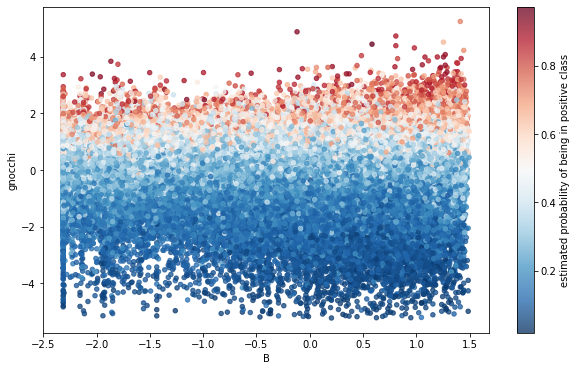

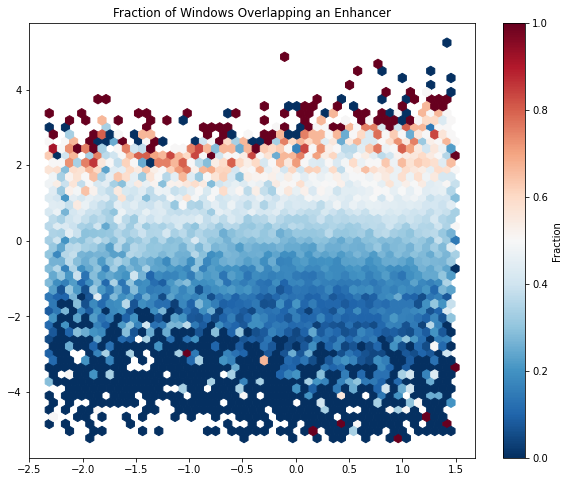

In [17]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler

def logistic_regression_heatmap(df, features, target, feature_to_plot):
    df = df.copy()

    print(len(df))
    # drop records with NaN values in any of the columns in "features": 
    df = df.dropna(subset=features)
    print(len(df))

    gnocchi_plus_features = ['gnocchi'] + features 

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df[gnocchi_plus_features], df[target], test_size=0.2, random_state=42)

    # X_train = np.array(X_train)
    # X_test = np.array(X_test)

    # Initialize a StandardScaler
    scaler = StandardScaler()

    # Fit the scaler with the training data and transform both training and testing data
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize a Logistic Regression model
    logreg = LogisticRegression()

    # Fit the model with the training data
    logreg.fit(X_train, y_train)

    # Print the coefficients of the features
    for feature, coef in zip(gnocchi_plus_features, logreg.coef_[0]):
        print(f'Coefficient for {feature}: {coef}')

    # Predict the probabilities
    y_pred_prob = logreg.predict_proba(X_test)[:, 1]

    feature_to_plot_index = gnocchi_plus_features.index(feature_to_plot)
    
    x = np.array(X_test[:,feature_to_plot_index]) # type: ignore
    y = np.array(X_test[:,0]) # type: ignore
    c = y_pred_prob

    # https://github.com/pandas-dev/pandas/issues/10611#issuecomment-522327555
    fig, axis = plt.subplots(figsize=(10,6))
    plt.scatter(x, y, c=c, s=20, cmap='RdBu_r', alpha=0.75) 
    plt.xlabel(gnocchi_plus_features[feature_to_plot_index])
    plt.ylabel('gnocchi')
    cbar = plt.colorbar()
    cbar.set_label('estimated probability of being in positive class')
    plt.show() 

    C = y_test
    # Plot the fraction as a hexbin plot
    # also see papers/neutral_models_are_biased/3.ipynb
    plt.figure(figsize=(10, 8))
    plt.hexbin(x, y, C=C, gridsize=50, cmap='RdBu_r', reduce_C_function=np.mean)
    plt.title('Fraction of Windows Overlapping an Enhancer')
    plt.colorbar(label='Fraction')
    plt.show()

# Call the function
logistic_regression_heatmap(WINDOWS, features=[f'GC_content_{GC_WINDOW_SIZE}bp', 'B_M1star.EUR', 'B'], target='window overlaps enhancer', feature_to_plot='B')

In [ ]:
# TODO: 

# Can logistic regression model correlations between features? 
# compute LRT statistic for gnocchi-only model vs gnocchi-plus-features model 
# consult previous notebooks where I performed logistic regression 


In [6]:
# TODO 

# 1. does the fact that the BGS distribution is truncated lead to a reduced regression coefficient for BGS?

In [7]:
# TODO
# 1. compute partial correlations of presence/absence of enhancer in window with gnocchi and features, 
#    and see whether the trend observed with regression coefficients is still present
# 2. what if we use the logistic regression model to re-compute PR curves? 
#    I'd expect that the PR curves for gBGC and BGS will not change much, but the PR curve for GC content will change a lot
#    If so, what does that mean? 